In [4]:
max_pixels=1003520
height , width =3024,1964
size = height*width
ratio = max_pixels/size
print(ratio,width,height)



0.16896733801010785 1964 3024


In [6]:
new_width = width * ratio
new_height = height * ratio
print(new_height,new_width)
# 4. Adjust for the divisibility factor
final_width = int(round(new_width / 28) * 28)
final_height = int(round(new_height / 28) * 28)
print(final_height,final_width)

510.9572301425662 331.85185185185185
504 336


In [13]:
import os
import glob
import re
from PIL import Image
import matplotlib.pyplot as plt
from datasets import Dataset
import pandas as pd
from IPython.display import display, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Define the base directory
base_dir = "screenshots/booking-dataset"
original_dir = base_dir
annotated_dir = os.path.join(base_dir, "annotated")

# Function to extract step number from filename
def extract_step_number(filename):
    """Extract step number from filename"""
    # Look for patterns like 'step0', 'step1', 'Step0', etc.
    match = re.search(r'[Ss]tep(\d+)', filename)
    if match:
        return int(match.group(1))
    return None

# Get all original images
original_files = glob.glob(os.path.join(original_dir, "*.png"))
original_files = [f for f in original_files if extract_step_number(os.path.basename(f)) is not None]

# Get all annotated images
annotated_files = glob.glob(os.path.join(annotated_dir, "*.png"))

# Create a mapping of step numbers to file paths
step_mapping = {}

for orig_file in original_files:
    step_num = extract_step_number(os.path.basename(orig_file))
    if step_num is not None:
        step_mapping[step_num] = {'original': orig_file, 'annotated': None}

for ann_file in annotated_files:
    step_num = extract_step_number(os.path.basename(ann_file))
    if step_num is not None and step_num in step_mapping:
        step_mapping[step_num]['annotated'] = ann_file

# Filter out steps that don't have both original and annotated images
complete_steps = {k: v for k, v in step_mapping.items() if v['original'] and v['annotated']}

print(f"Found {len(complete_steps)} complete step pairs:")
for step_num in sorted(complete_steps.keys()):
    print(f"Step {step_num}: {os.path.basename(complete_steps[step_num]['original'])} -> {os.path.basename(complete_steps[step_num]['annotated'])}")


Found 20 complete step pairs:
Step 0: Screenshot 2025-06-12 at 14.19.11-Step0.png -> annotated_booking-dataset_step0.png
Step 1: Screenshot 2025-06-12 at 14.20.12-step1.png -> annotated_booking-dataset_step1.png
Step 2: Screenshot 2025-06-12 at 14.22.20-step2.png -> annotated_booking-dataset_step2.png
Step 3: Screenshot 2025-06-12 at 14.30.39-step3.png -> annotated_booking-dataset_step3.png
Step 4: Screenshot 2025-06-12 at 14.23.55-step4.png -> annotated_booking-dataset_step4.png
Step 5: Screenshot 2025-06-12 at 14.24.08-step5.png -> annotated_booking-dataset_step5.png
Step 6: Screenshot 2025-06-12 at 14.24.27-step6.png -> annotated_booking-dataset_step6.png
Step 7: Screenshot 2025-06-12 at 14.24.36-step7.png -> annotated_booking-dataset_step7.png
Step 8: Screenshot 2025-06-12 at 14.24.46-step8.png -> annotated_booking-dataset_step8.png
Step 9: Screenshot 2025-06-12 at 14.24.50-step9.png -> annotated_booking-dataset_step9.png
Step 10: Screenshot 2025-06-12 at 14.25.04-step10.png -> ann

In [14]:
# Alternative approach using simple input() instead of widgets
# This is more reliable across different Jupyter environments

def collect_dataset_data_simple(complete_steps):
    """Simple data collection using input() prompts"""
    dataset_data = []
    sorted_steps = sorted(complete_steps.keys())
    
    print("Starting data collection process...")
    print("For each image, you'll be asked to provide:")
    print("1. Localization: Describe what elements/objects are visible and their locations")
    print("2. Navigation: Describe what action should be taken or what the user should do")
    print("\nNote: Type 'skip' to skip a step, 'quit' to stop and save current progress")
    print("=" * 60)
    
    for i, step_num in enumerate(sorted_steps):
        step_data = complete_steps[step_num]
        
        print(f"\n--- Step {step_num} ({i + 1}/{len(sorted_steps)}) ---")
        print(f"Original image: {os.path.basename(step_data['original'])}")
        print(f"Annotated image: {os.path.basename(step_data['annotated'])}")
        
        # Display the original image
        img = Image.open(step_data['original'])
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Step {step_num} - Original Image")
        plt.tight_layout()
        plt.show()
        
        # Get user input for localization
        print("\n1. LOCALIZATION:")
        print("   Describe what UI elements, text, buttons, etc. are visible and their locations")
        localization = input("   > ").strip()
        
        if localization.lower() == 'quit':
            print("\nStopping data collection...")
            break
        elif localization.lower() == 'skip':
            print(f"Skipping Step {step_num}")
            continue
            
        # Get user input for navigation
        print("\n2. NAVIGATION:")
        print("   Describe what action should be taken next or what the user should do")
        navigation = input("   > ").strip()
        
        if navigation.lower() == 'quit':
            print("\nStopping data collection...")
            break
        elif navigation.lower() == 'skip':
            print(f"Skipping Step {step_num}")
            continue
        
        # Store the data
        dataset_data.append({
            'step_number': step_num,
            'original_image_path': os.path.relpath(step_data['original']),
            'annotated_image_path': os.path.relpath(step_data['annotated']),
            'localization': localization,
            'navigation': navigation
        })
        
        print(f"✓ Data saved for Step {step_num}")
    
    # Create and save the dataset
    if dataset_data:
        print(f"\n{'='*60}")
        print(f"Creating dataset with {len(dataset_data)} entries...")
        
        # Create DataFrame
        df = pd.DataFrame(dataset_data)
        df = df.sort_values('step_number').reset_index(drop=True)
        
        # Create Hugging Face dataset
        dataset = Dataset.from_pandas(df[['original_image_path', 'annotated_image_path', 'localization', 'navigation']])
        
        print(f"Dataset created with {len(dataset)} rows!")
        print("\nDataset preview:")
        print(df.head())
        
        # Save the dataset
        dataset.save_to_disk("booking_dataset")
        df.to_csv("booking_dataset.csv", index=False)
        
        print("\nDataset saved to:")
        print("- Hugging Face format: booking_dataset/")
        print("- CSV format: booking_dataset.csv")
        
        return dataset
    else:
        print("No data collected!")
        return None

# Start the data collection
print("Ready to start data collection!")
print("Run the following line to begin:")
print("dataset = collect_dataset_data_simple(complete_steps)")


Ready to start data collection!
Run the following line to begin:
dataset = collect_dataset_data_simple(complete_steps)


Starting data collection process...
For each image, you'll be asked to provide:
1. Localization: Describe what elements/objects are visible and their locations
2. Navigation: Describe what action should be taken or what the user should do

Note: Type 'skip' to skip a step, 'quit' to stop and save current progress

--- Step 0 (1/20) ---
Original image: Screenshot 2025-06-12 at 14.19.11-Step0.png
Annotated image: annotated_booking-dataset_step0.png


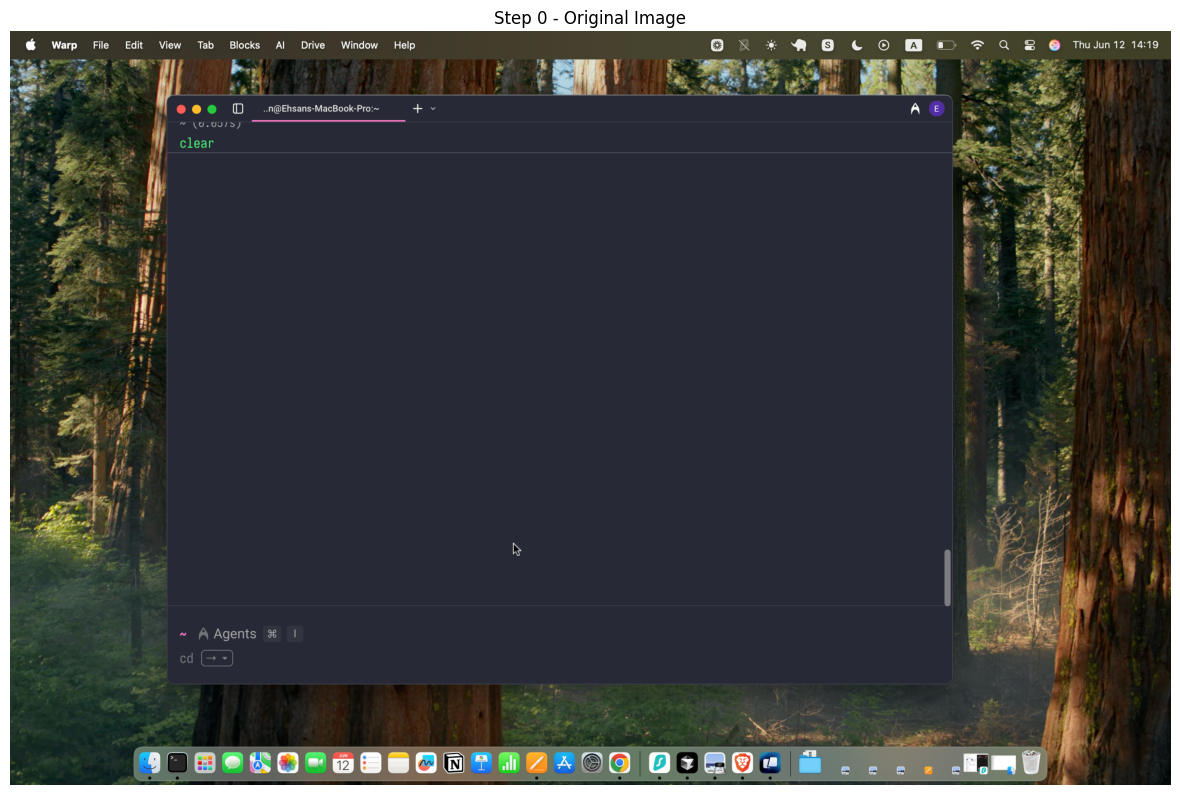


1. LOCALIZATION:
   Describe what UI elements, text, buttons, etc. are visible and their locations

2. NAVIGATION:
   Describe what action should be taken next or what the user should do
✓ Data saved for Step 0

--- Step 1 (2/20) ---
Original image: Screenshot 2025-06-12 at 14.20.12-step1.png
Annotated image: annotated_booking-dataset_step1.png


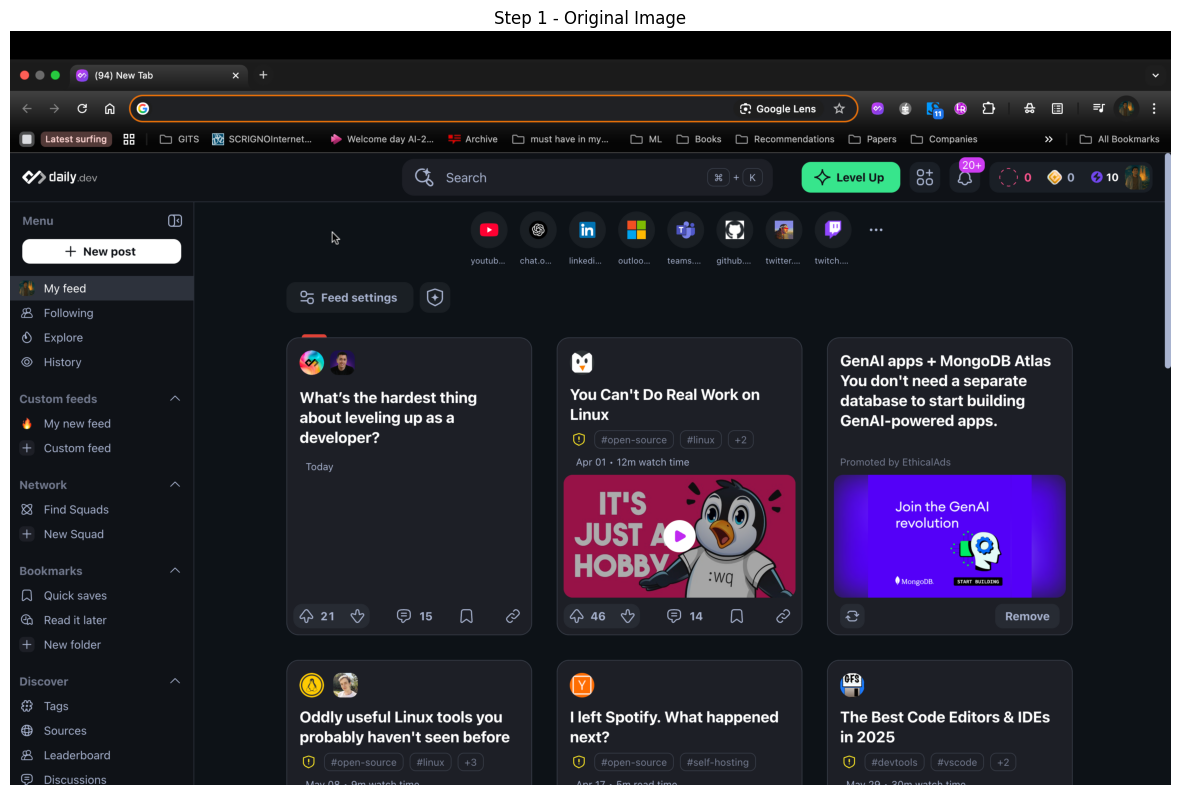


1. LOCALIZATION:
   Describe what UI elements, text, buttons, etc. are visible and their locations

Stopping data collection...

Creating dataset with 1 entries...
Dataset created with 1 rows!

Dataset preview:
   step_number                                original_image_path  \
0            0  screenshots/booking-dataset/Screenshot 2025-06...   

                                annotated_image_path localization navigation  
0  screenshots/booking-dataset/annotated/annotate...            1          1  


Saving the dataset (1/1 shards): 100%|██████████| 1/1 [00:00<00:00, 284.32 examples/s]


Dataset saved to:
- Hugging Face format: booking_dataset/
- CSV format: booking_dataset.csv


In [12]:
# Execute this cell to start the data collection process
dataset = collect_dataset_data_simple(complete_steps)
